In [ ]:
# info needed:
'''
data points:velocity and radius
z0 [kpc], distance [Mpc],density points: (kpc,mag/arcsec**2) or 
(kpc,msun/pc**2) for bulge, disk, gas
Optional: mass of bulge, disk, central black hole mass
'''

In [3]:
# Imports

import sys
sys.path.append('../../python/')
# What does this^ do?

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import scipy.interpolate as inter

import dataPython as dp
import NGC5533_functions_newmag as nf
#import noordermeer as noord

from datetime import datetime
import time
# Why did they use this^?

If you do, DISCARD ALL CHANGES TO THE FILE.
Your calculations will NOT be consistent with this library's equations if you use the disk.hdf5 or bulge.hdf5 files,
and if you write to that file it will contain calculations based on conflicting constants.
Worst case scenario, reset the disk.hdf5 file to before the commit where you used this library to write to it.


In [5]:
#import data files:
#starttime = time.time()

#TRACING:**************************************
#Creating arrays based off ngc5005 traced data 

data = dp.getXYdata_wXYerr('../..//NGC_5005/traced_data/ngc5005_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#gas rotmod:
gas_rdata = dp.getXYZdata('../aygas.dat')
rgasr = gas_rdata['xx']
rgasv = gas_rdata['zz']
rgasv = np.asarray(rgasv)
rgasv_spline = inter.InterpolatedUnivariateSpline(rgasr,rgasv,k=5)
rgasv_fit = rgasv_spline(r_dat)
rgasv_fit = rgasv
# ^^Why is rgasv_fit defined twice?

#bulge rotmod
bulge_rdata = dp.getXYZdata('../aybulge.dat') 
rbulger = bulge_rdata['xx']
rbulgev = bulge_rdata['zz']
rbulgev=np.asarray(rbulgev)
rbulgev_spline = inter.InterpolatedUnivariateSpline(rbulger,rbulgev,k=5)
rbulgev_fit = rbulgev_spline(r_dat)
rbulgev_fit=rbulgev

#disk rotmod:
disk_rdata = dp.getXYZdata('../aydisk.dat')
rdiskr = disk_rdata['xx']
rdiskv = disk_rdata['zz']
rdiskv=np.asarray(rdiskv)
rdiskv_spline = inter.InterpolatedUnivariateSpline(rdiskr,rdiskv,k=5)
rdiskv_fit = rdiskv_spline(r_dat)
rdiskv_fit=rdiskv

#Halo datathief trace:
halo_dt = dp.getXYdata('../../NGC_5005/datatheif_halo_spline.txt')
halo_dtr = halo_dt['xx']
halo_dtv = halo_dt['yy']
halo_dtv=np.asarray(halo_dtv)
halo_dtv_spline = inter.InterpolatedUnivariateSpline(halo_dtr,halo_dtv,k=5)
halo_dtv_fit = halo_dtv_spline(r_dat)

rval = np.linspace(0,11.2,19)                     

In [6]:
# Fitting function, just prefactors for all the components
def g(r,GX,BX,DX,rc,rho00):
    return np.sqrt((GX*rgasv_fit)**2
                  +(BX*rbulgev_fit)**2
                  + (DX*rdiskv_fit)**2
                  + (nf.h_v(rval,rc,rho00))**2) 

In [10]:
v_err1 = v_err1
weighdata = 1/v_err1
# Why did they set a variable equal to itself?

#setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()

#Gas
g_params.add('GX', value = .956, min = .956) 

#Bulge
g_params.add('BX', value=1, min=0)    

#Disk
g_params.add('DX', value=1, min=0)    

#Halo
g_params.add('rc', value=2.5, min=2.5, max=2.51)    #Core radius (kpc)
g_params.add('rho00', value=1e+08, min=0)           #Central density

#Do Fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

An error has occured. Switching to save function. Error information below:
<class 'OSError'>
Unable to open file (unable to open file: name = './/halo.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

#--------------------


Traceback (most recent call last):
  File "../../python\NGC5533_functions_newmag.py", line 349, in h_viso
    y = loaddata(comp,'rc'+str(rc)+'rho00'+str(rho00),file=comp+'.hdf5',**kwargs)[1]
  File "../../python\NGC5533_functions_newmag.py", line 142, in loaddata
    saved = h5.File(path+'/'+file,'r')
  File "C:\Users\Rachel\anaconda3\lib\site-packages\h5py\_hl\files.py", line 406, in __init__
    fid = make_fid(name, mode, userblock_size,
  File "C:\Users\Rachel\anaconda3\lib\site-packages\h5py\_hl\files.py", line 173, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py\_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py\_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py

In [11]:
# Define for plotting
bestg = g_fit.best_fit
print('Fit information for all-component fit:')
g_fit

Fit information for all-component fit:


In [13]:
#smoothing --> creating a spline

r_dat_andzero = np.append([0],r_dat)
idx = np.arange(0,np.shape(r_dat_andzero)[0])
# ^^tf?

bestg = bestg[r_dat.argsort()]

rgasv_spline = inter.InterpolatedUnivariateSpline(rgasr,rgasv,k=5)
rgasv_fit = rgasv_spline(r_dat)
# ^^ Why is this here and after the ROTMOD gas?
# ^^ And why isn't it followed by rgasv_fit=rgasv like the others?

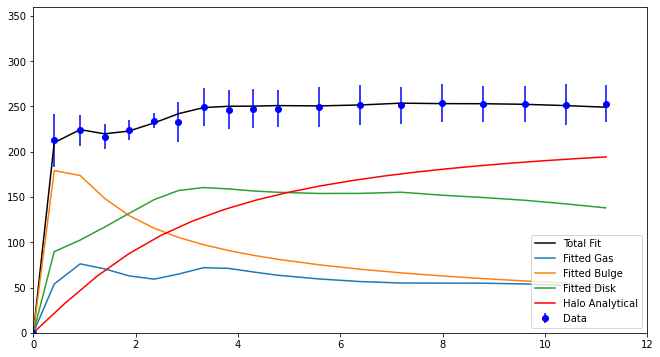

In [14]:
#Define for plotting cont.

g_dict = g_fit.best_values
g_g = g_dict['GX']
g_b = g_dict['BX']
g_d = g_dict['DX']
g_rc = g_dict['rc']
g_rho00 = g_dict['rho00']
halo_curve = nf.h_v(rval,g_rc,g_rho00)

plt.figure(figsize=(11,6))
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo', label='Data')

plt.plot(r_dat,bestg,'k',label='Total Fit')
plt.plot(rgasr,g_g*rgasv_fit,label='Fitted Gas')
plt.plot(rbulger,g_b*rbulgev,label='Fitted Bulge')
plt.plot(rdiskr,g_d*rdiskv,label='Fitted Disk')
plt.plot(rval,halo_curve,'r-',label='Halo Analytical')

halo_curve=halo_curve[:len(halo_curve)-6]
halo_curve=halo_curve[0::6]
# ^^ No clue what is going on here...

plt.legend(loc='lower right')
plt.ylim(0,360)
plt.xlim(0,12)
plt.show()